# A Step-By-Step Componential Analysis of Deep Neural Networks

# 1. Data Collection

### The analysis of the fundamental components of this deep neural network are done with the MNIST handwritten digit dataset, which has a training set of 60 000 examples, and a test set of 10 000 examples.

#### Consider an example digit below:

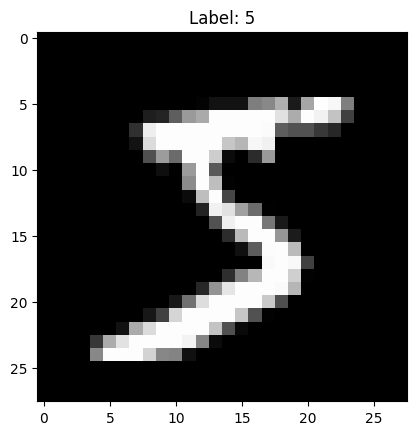

In [90]:
train_data_df = pd.read_csv('mnist_train_labeled.csv')

label = train_data_df.iloc[0, 0] 
image_data = train_data_df.iloc[0, 1:].values

image = image_data.reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

#### Each image is a 28 x 28 pixel image with a grayscale pixel value from 0 - 255 representing brightness -- 0 represents black which can be interpreted as turned off, whereas 255 represents a turned on cell. Each 1 / 784 cells carries their repective pixel value.

# 2. Data PreProcessing

#### Data is extracted by splitting numbers into groups of pixels corresponding to their respective label. This data is fed into the neural network while maintaining each mapping of label to pixel values.

In [100]:
import pandas as pd
import numpy as np

def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 1:].values  # Pixel values (skip the first column which is the label)
    Y = data.iloc[:, 0].values   # Labels (first column)
    return X, Y

def preprocess_data(X, Y):
    X = X / 255.0
    X = (X * 255).astype(int)
    return X, Y

X_train, Y_train = preprocess_data(*load_data('mnist_train.csv'))

num_pixels = X_train.shape[1]
pixel_headers = [f'pixel_{i}' for i in range(num_pixels)]
headers = ['label'] + pixel_headers

# Combine the labels and pixel data into a DataFrame
train_data_df = pd.DataFrame(np.column_stack((Y_train, X_train)), columns=headers)

print("Labeled Training Data:")
print(train_data_df.head(5))


Labeled Training Data:
   label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0      0        0        0        0        0        0        0        0   
1      4        0        0        0        0        0        0        0   
2      1        0        0        0        0        0        0        0   
3      9        0        0        0        0        0        0        0   
4      2        0        0        0        0        0        0        0   

   pixel_7  pixel_8  ...  pixel_774  pixel_775  pixel_776  pixel_777  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          0          0          0          0   
3        0        0  ...          0          0          0          0   
4        0        0  ...          0          0          0          0   

   pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  
0          0          0

##### *Note: For cleanliness all values have been converted from float to int*.

#### Data is normalized to give the data a consistent range across the network. This enhances the processing of data and therefore acts as a preventive measure for nuissances such as the vanishing gradient problem.

In [ ]:
def preprocess_data(X, Y):
    X = X / 255.0
    X = (X * 255).astype(int)
    return X, Y

# 3. Neural Network Architecture

### *He Initialization* is used to introduce proper variance and scaling throughout layers of the network to avoid exploding or vanishing gradients during propagation.

In [101]:
class NeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for weights
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((output_size, 1))

#### A hidden layer introduces non-linearity through activation functions. This is needed to establish the capability of learning and complex problem solving.

![For a visual](../Downloads/mlp.png)

*Note: Not drawn to scale*

# 4. Training the Deep Neural Network

#### Weights are initialized by:

   $$
         w_1 = \mathcal{N}(0,1) \cdot \sqrt{\frac{2.0}{\text{input size}}}
     $$
     $$
         w_2 = \mathcal{N}(0,1) \cdot \sqrt{\frac{2.0}{\text{hidden size}}}
      $$

Each weight is scaled by a factor of $ \sqrt{\frac{2.0}{n}} $ to maintain variance across layers, and lead to convergence across training epochs. Biases are independant of input scaling and are adjusted throughout the training hence their staring position of 0.

In [106]:
def forward_propagation(self, X, keep_prob):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = np.maximum(0, self.Z1)

        # Dropout for the hidden layer
        self.dropout_mask1 = (np.random.rand(*self.A1.shape) < keep_prob) / keep_prob
        self.A1 *= self.dropout_mask1

        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

### Forward propagation is used to recieve input, calculate weighted sums and generate output.

##### 1. Each weighted sum is given by: 

$$
    z = \sum_j w_jx_j + b
$$

*Note: $x_j$ represents input for the j-th neuron*.

Where z is the activation (weighted sum) for the j-th node in the following layer. Neurons are then randomly dropped out with regularization to reduce opverfitting so the dropout mask is applied layer by layer to the Activation $ A_{1,j} $ as follows: $ A'_{1,j} \rightarrow A_{1,j} \cdot \text{DropoutMask}_{1,j} $. This prevents a single dataset from dominating the model.

In [110]:
def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

#### The softmax function is applied to the entire vector of outputs from the output layer by: 

$$ a_j^L = \frac{e^{z_j^L}}{\sum_k e^{z_k^L}} \rightarrow  \sum_j a_j^L = \frac{\sum_j e^{z_j^L}}{\sum_k e^{z_k^L}} = 1 $$

The $ e^{z_j^L} $ term transforms all logits into positive numbers (essential for probabilities). The sum of all exponentiated logits in the denominator normalizes all inputs. This transforms the resulting output as an interpretation of probabilities between 0 and 1. The highest proabability in the final layer is the network's guess of which digit the image represents.

### Main Training 

In [ ]:
def train(self, X_train, Y_train, X_test, Y_test, iterations, initial_learning_rate, batch_size, lambda_, keep_prob, decay_rate=0.96, decay_step=100):
        m_train = X_train.shape[1]
        m_test = X_test.shape[1]
        train_costs = []
        test_costs = []
        train_accuracies = []
        test_accuracies = []
        learning_rates = [] 

        learning_rate = initial_learning_rate

        for i in range(iterations):
            # Update learning rate using exponential decay
            learning_rate = initial_learning_rate * decay_rate**(i // decay_step)
            learning_rates.append(learning_rate)

            #shuffle training data (preventing bias)
            permutation = np.random.permutation(m_train)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]

            epoch_cost = 0

            for j in range(0, m_train, batch_size):
                #randomly shuffle data
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                A2 = self.forward_propagation(X_batch, keep_prob)
                cost = self.compute_cost(A2, Y_batch, lambda_)
                dW1, db1, dW2, db2 = self.back_propagation(X_batch, Y_batch, A2, keep_prob)
                self.W1 -= learning_rate * dW1
                self.b1 -= learning_rate * db1
                self.W2 -= learning_rate * dW2
                self.b2 -= learning_rate * db2

                # Accumulate cost, weighted by batch size
                epoch_cost += cost * X_batch.shape[1]

            # Average cost over the epoch
            epoch_cost /= m_train
            train_costs.append(epoch_cost)

            # Compute test cost
            A2_test = self.forward_propagation(X_test, keep_prob)
            test_cost = self.compute_cost(A2_test, Y_test, lambda_)
            test_costs.append(test_cost)

### Key Componenents

#### Learning Rate Scheduler

Early in training, a high learning rate helps quickly adjust weights that are initially far off. As training progresses and weights become more refined, reducing the learning rate allows for more precise adjustments. This is calculated through updating the learning rate and multiyplying it to a decay rate and modified floor function for a fixed interval updating effect:

$$
    \eta_i = \eta_0 \cdot \gamma^{\left\lfloor \frac{i}{k} \right\rfloor}
$$

and its python equivalent

``` learning_rate = initial_learning_rate * decay_rate**(i // decay_step) ```

*Note that that $ \eta_i $ changes every $ kth $ epoch*

#### Mini-Batch Gradient Descent

Following forward propagation and softmaxing, mini-batch gradient descent is implemented to help the neural network learn. Main componenets of this step are computing the cost-loss, back propagation, and updating hyperparameters while maintaining key features such as dropout and regularization.

   __Cross-Entropy__

Cross-entropy is a loss function used to measure the performance of the model. With a regularization term, the loss function can generalize its learning capabilities better, as it penalizes larger weights and encourages smaller weights. This improves the models genralizability to identify numbers correctly outside the training data.

In [123]:
def compute_cost(self, A2, Y, lambda_):
        m = Y.shape[1]
        cross_entropy_cost = -np.sum(Y * np.log(A2 + 1e-8)) / m  # Cross-entropy cost
        L2_regularization_cost = (lambda_ / (2 * m)) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        cost = cross_entropy_cost + L2_regularization_cost
        return cost

Cross-Entropy is calculated by:

$$ 
C = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{c} Y_{j}^{(i)} \log(A_{2,j}^{(i)} + \epsilon) + \frac{\lambda}{2m} \left( \|w_1\|^2 + \|w_2\|^2 \right)
$$


 - $ m $ is the number of training examples
- $ c $ is the number of classes (10 since there are 10 digits from 0-9)
- $ Y_j^{(i)} $ is the true label for class j in the i-th example
- $ A_{2,j}^{(i)} $ is the predicted probability for class j in the i-th example
- $ \epsilon $ is a small constant added to avoid producing a logarithm of zero
- $ \lambda $ is the regularization parameter
- $ w_1 $ and $ w_2 $ are the norms of the weight vectors of the first and second layers

*Note that if the predicted probability is accurate, $ A_{2,j}^{(i)} $ is high and the loss is small. The converse is also true.*

Consider $
\lim_{A_{2,j}^{(i)} \to 1} -\log(A_{2,j}^{(i)} + \epsilon)
$


> As $lim_{A_{2,j}^{(i)} \to 1}$ the term $ \log(A_{2,j}^{(i)} + \epsilon) $ approaches $ log(1) = 0 $. Thus $ -\log(A_{2,j}^{(i)} + \epsilon) $ approaches 0 which means the loss is low -- indicating accurate predictions and effective learning. The converse is true as $lim_{A_{2,j}^{(i)} \to 0}$$ -\log(A_{2,j}^{(i)} + \epsilon) $ becomes very negative because $ \log(\epsilon) $ is negative and $ \log(A_{2,j}^{(i)}) $ diverges to $ -\infty $. This in turn causes $-\log(A_{2,j}^{(i)} + \epsilon) $ to grow exponentially large, resulting in a very high cost.

In a high cost result, the cross-entropy term dominates so the paramterized term reduces its contribution to the prediction. Therefore the model is encouraged to keep weights smaller.

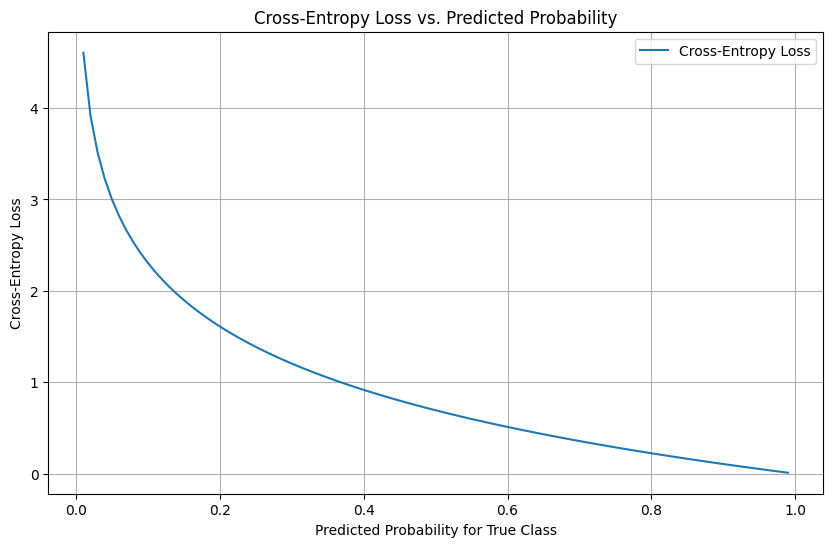

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 1e-8
true_class_prob = 1  # For the true class

#Range of predicted probabilities
predicted_probs = np.linspace(0.01, 0.99, 100)  # Avoid 0 and 1 to prevent log(0)
cross_entropy_losses = -np.log(predicted_probs + epsilon)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(predicted_probs, cross_entropy_losses, label='Cross-Entropy Loss')
plt.xlabel('Predicted Probability for True Class')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss vs. Predicted Probability')
plt.grid(True)
plt.legend()
plt.show()

__Figure 1__: the Relationship Between Predicted Probability and Cross-Entropy Loss Across a Deep Neural Network

__Back Propagation__

Back propagation's goal is to determine how the parameters must be adjusted to reduce the cost function and improve overall accuracy.

In [122]:
def back_propagation(self, X, Y, A2, keep_prob):
        m = X.shape[1]
        ## predicted output - true label
        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.dot(self.W2.T, dZ2) * (self.A1 > 0) 

        #droput to prevent overfitting
        dZ1 *= self.dropout_mask1

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
        return dW1, db1, dW2, db2

Every Epoch, partial derivatives of the weights and biases are taken to find the adjustments to take to minimize error. $ \partial w_2 $ indicates the magnitude and direction in which the next layer should take to minimize error. $ \partial b_2 $ indicates how to change the bias to minimize the cost function. Scaling by $ \frac{1}{m} $ keeps the gradient calculations consistent across different mini-batch sizes. 

Consider ```dZ1 = np.dot(self.W2.T, dZ2) * (self.A1 > 0) ``` which is equivalent to

$ \partial z_1 = \frac{\partial C}{\partial z_1} = (\frac{\partial C}{\partial z_2} \cdot w_2^T) \cdot f'(z_1)$

> - The error $ \frac{\partial C}{\partial z_2} $ from the second layer is propagated back to the first layer using $ w_2 $. This error is adjusted accoriding to the function in the first layer by multyplying with the derivative of the ReLU function ```self.A1 > 0 ```. This accounts for neuron sensitivity in relationship to changes in the input throughout the layers. The propagation helps the network learn and make better predictions.

By propagating the error back through the network and adjusting the weights accordingly, the network "learns" to make better predictions.

![For a visual](../Downloads/gd.png)

__Figure 2__: A Neural Network Finding Its Minima Throughout Successive Epochs.

__Updating Weights and Biases__

Adjusting parameters in the opposite direction of the gradient of the loss function points in the direction of steepest decrease in the function's value. As a result this decreases the function optimally. The learning rate controls the size of steps to take to reach this minimum. Adjusting the weights and biases by the multiplication of these two variables leads to the convergence to the desired minimum.

Weight and Biases are updated by:

$$
    w_1 \leftarrow w_1 - \eta (\frac{\partial C}{\partial w_1})
$$
$$
    b_1 \leftarrow b_1 - \eta(\frac{\partial C}{\partial b_1})
$$
$$
    w_2 \leftarrow w_2 - \eta(\frac{\partial C}{\partial w_2})
$$
$$
    b_2 \leftarrow b_2 - \eta(\frac{\partial C}{\partial w_2})
$$

*Derivation with Taylor Expansion*

Consider the Taylor expansion of the cost function $ C(w_1) $ where $ C $ is to be minimized, $ w_1 $ is the weight of the first layer, and $ \Delta w_1 $ is the change in $ w_1 $:

$$
    f(x) = f(x_0) + \frac{f'(x_0)}{1!}(x-x_0) + \frac{f''(x_0)}{2!}(x-x_0)^2 \dots
$$
$$
    C(w_1 + \Delta w_1) = C(w_1) + \frac{\partial C}{\partial w_1}\Delta w_1 + \frac{1}{2!} \frac{\partial^2C}{\partial w_1^2}(\Delta w_1)^2 + \dots
$$


Higher order terms minimally affect the result compared to the first-order term. This term can find the local approximation at a certain point, leading to the direction and magnitude of the step the gradient should take to minimize the cost function. Thus the approximation can be made: 

$$
    C(w_1 + \Delta w_1) \approx C(w_1) + \frac{\partial C}{\partial w_1}\Delta w_1
$$

To minimize $ C $, a $ \Delta w_1 $ should be chosen to reduce it. Thus the term $\frac{\partial C}{\partial w_1}\Delta w_1$ should be negative since the slope of a function can be interpreted from its first derivative. So the equality $ \frac{\partial C}{\partial w_1} \Delta w_1 < 0 $ must hold true. We know the learning rate $ \eta $ can optimally navigate the local minima as well as efficiently speed up convergence. So the new $ \Delta w_1 $ is:

$$
    \Delta w_1 = -\eta\frac{\partial C}{\partial w_1}
$$

Updating $ w_1 $:

$$ 
    w_{1\text{new}} = w_1 + \Delta w_1
$$

Substitute $ \Delta w_1 $

$$
    W_{1\text{new}} = w_1 -\eta\frac{\partial C}{\partial w_1}
$$

Q.E.D.

# 4. Evaluating the Model

In [128]:
def evaluate(self, X, Y, keep_prob=1.0):
        A2 = self.forward_propagation(X, keep_prob)
        predictions = np.argmax(A2, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

Every 10 epochs, the output of the network for a given input will be a vector of probabilities, where each element in the vector represents the probability that the input belongs to a particular class. It compares the predicted to the true label and returns the accuracy.

# 5. Training The Model

Training the model and visualizing its learning process.

In [136]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 1:].values  
    Y = data.iloc[:, 0].values   
    return X, Y

def preprocess_data(X, Y):
    # Normalize features
    X = X / 255.0
    # One-hot encode labels
    Y_encoded = np.eye(np.max(Y) + 1)[Y]
    
    return X.T, Y_encoded.T

class NeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for weights
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((output_size, 1))
    
    def forward_propagation(self, X, keep_prob):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = np.maximum(0, self.Z1)

        # Dropout for the hidden layer
        self.dropout_mask1 = (np.random.rand(*self.A1.shape) < keep_prob) / keep_prob
        self.A1 *= self.dropout_mask1

        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    def train(self, X_train, Y_train, X_test, Y_test, iterations, initial_learning_rate, batch_size, lambda_, keep_prob, decay_rate=0.96, decay_step=100):
        m_train = X_train.shape[1]
        m_test = X_test.shape[1]
        train_costs = []
        test_costs = []
        train_accuracies = []
        test_accuracies = []
        learning_rates = []

        learning_rate = initial_learning_rate

        for i in range(iterations):
            # Update learning rate using exponential decay
            learning_rate = initial_learning_rate * decay_rate**(i // decay_step)
            learning_rates.append(learning_rate)

            permutation = np.random.permutation(m_train)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]

            epoch_cost = 0

            for j in range(0, m_train, batch_size):
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                A2 = self.forward_propagation(X_batch, keep_prob)
                cost = self.compute_cost(A2, Y_batch, lambda_)
                dW1, db1, dW2, db2 = self.back_propagation(X_batch, Y_batch, A2, keep_prob)
                self.W1 -= learning_rate * dW1
                self.b1 -= learning_rate * db1
                self.W2 -= learning_rate * dW2
                self.b2 -= learning_rate * db2

                epoch_cost += cost * X_batch.shape[1]

            epoch_cost /= m_train
            train_costs.append(epoch_cost)

            # Compute test cost
            A2_test = self.forward_propagation(X_test, keep_prob)
            test_cost = self.compute_cost(A2_test, Y_test, lambda_)
            test_costs.append(test_cost)

            if i % 10 == 0:
                train_accuracy = self.evaluate(X_train, Y_train, keep_prob)
                test_accuracy = self.evaluate(X_test, Y_test, keep_prob)
                train_accuracies.append(train_accuracy * 100)
                test_accuracies.append(test_accuracy * 100)

                print(f"Epoch {i} | Training Accuracy = {train_accuracy * 100:.5f}% | Test Accuracy = {test_accuracy * 100:.5f}%\n")

        return train_costs, test_costs, train_accuracies, test_accuracies, learning_rates



    def compute_cost(self, A2, Y, lambda_):
        m = Y.shape[1]
        cross_entropy_cost = -np.sum(Y * np.log(A2 + 1e-8)) / m
        L2_regularization_cost = (lambda_ / (2 * m)) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        cost = cross_entropy_cost + L2_regularization_cost
        return cost
    
    def back_propagation(self, X, Y, A2, keep_prob):
        m = X.shape[1]
        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.dot(self.W2.T, dZ2) * (self.A1 > 0)

        dZ1 *= self.dropout_mask1

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
        return dW1, db1, dW2, db2

    def evaluate(self, X, Y, keep_prob=1.0):
        A2 = self.forward_propagation(X, keep_prob)
        predictions = np.argmax(A2, axis=0)
        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

# Step 4: Save and Load Model
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


#Load and preprocess the data, adjust accoridngly to dataset
X_train, Y_train = preprocess_data(*load_data('mnist_train.csv'))
X_test, Y_test = preprocess_data(*load_data('mnist_test.csv'))

#Parameters
input_size = X_train.shape[0]
hidden_size = 128
output_size = 10
iterations = 300
initial_learning_rate = 0.01
batch_size = 64  

lambda_ = 0.01
#keep 80% of data
keep_prob = 0.8 

model = NeuralNetwork(input_size, hidden_size, output_size)
train_costs, test_costs, train_accuracies, test_accuracies, learning_rates = model.train(
    X_train, Y_train, X_test, Y_test, iterations, initial_learning_rate, batch_size, lambda_, keep_prob)

#Save the model
save_model(model, 'neural_network_model.pkl')

Epoch 0 | Training Accuracy = 84.57141% | Test Accuracy = 85.39854%

Epoch 10 | Training Accuracy = 93.25989% | Test Accuracy = 93.41934%

Epoch 20 | Training Accuracy = 95.01325% | Test Accuracy = 94.69947%

Epoch 30 | Training Accuracy = 95.78326% | Test Accuracy = 95.44954%

Epoch 40 | Training Accuracy = 96.42494% | Test Accuracy = 95.90959%

Epoch 50 | Training Accuracy = 96.83495% | Test Accuracy = 96.35964%

Epoch 60 | Training Accuracy = 97.10162% | Test Accuracy = 96.41964%

Epoch 70 | Training Accuracy = 97.30329% | Test Accuracy = 96.69967%

Epoch 80 | Training Accuracy = 97.53496% | Test Accuracy = 96.84968%

Epoch 90 | Training Accuracy = 97.74330% | Test Accuracy = 96.91969%

Epoch 100 | Training Accuracy = 97.92830% | Test Accuracy = 97.21972%

Epoch 110 | Training Accuracy = 98.05330% | Test Accuracy = 97.19972%

Epoch 120 | Training Accuracy = 98.15330% | Test Accuracy = 97.09971%

Epoch 130 | Training Accuracy = 98.23330% | Test Accuracy = 97.37974%

Epoch 140 | Train

#### Notice the similarity between training and test data, concluding adequate generalization to new and unseen data.

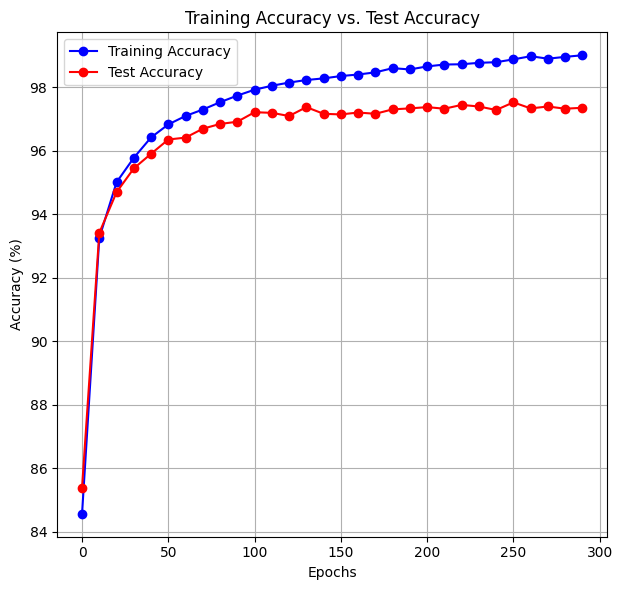

In [137]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, len(train_accuracies) * 10, 10), train_accuracies, label='Training Accuracy', color='blue', marker = "o")
plt.plot(range(0, len(test_accuracies) * 10, 10), test_accuracies, label='Test Accuracy', color='red', marker = "o")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Test Accuracy')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

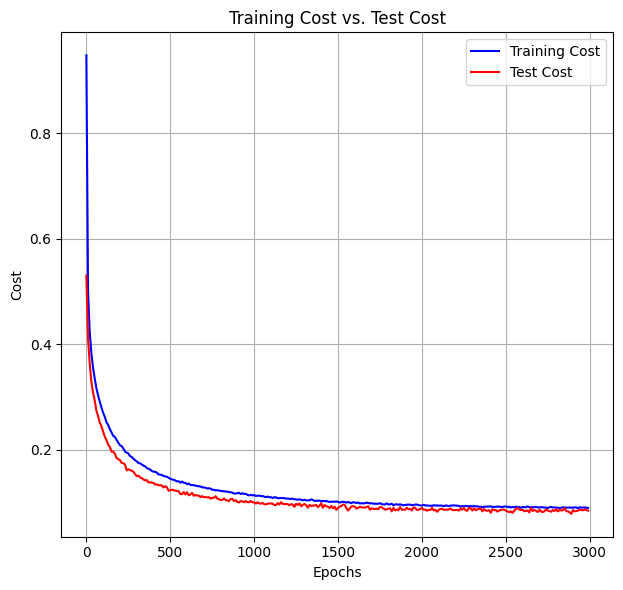

In [140]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost', color='blue')
plt.plot(range(0, len(test_costs)*10, 10), test_costs, label='Test Cost', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training Cost vs. Test Cost')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

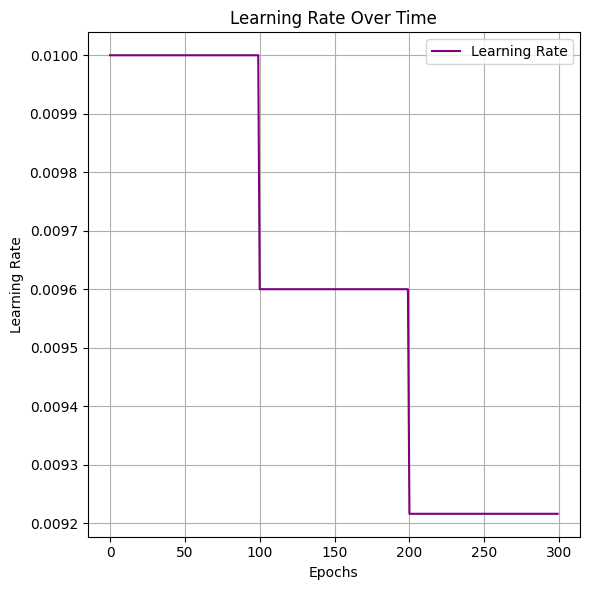

In [139]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost', color='blue')
plt.plot(range(0, len(test_costs)*10, 10), test_costs, label='Test Cost', color='red')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training Cost vs. Test Cost')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()